# Second home assignment Social Data Science

## Mahalanobis matching
Another popular alternative to propensity score matching is "Mahalanobis matching". This is a greedy matching method, where each point of one group is matched to its nearest neighbor according to the Mahalanobis distance, see https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.spatial.distance.mahalanobis.html for a formal definition. 



### Data preparation:
We apply Mahalanobis matching to the quality of government (QoG) data from the last home assignment. For this task, first load the QoG data into a pandas dataframe and select the columns "cname","wdi_lifexp" (life expectancy),"wdi_popden"(population density),"gle_cgdpc" (GDP per capita), "bti_ds" (Democracy Status).

Remove all countries with missing values. Then put all remaining countries into two groups:
* Full democratic (bti_ds > 8.0)
* Not full democratic (else)

In [32]:
import pandas as pd
import numpy as np
import scipy as sp
import sklearn
from scipy import stats
import matplotlib.pyplot as plt

In [4]:
url = 'https://www.qogdata.pol.gu.se/data/qog_bas_cs_jan18.csv'
df_temp = pd.read_csv(url)
df = df_temp[['cname', 'wdi_lifexp', 'wdi_popden', 'gle_cgdpc', 'bti_ds']]
#df = df.set_index('cname')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194 entries, 0 to 193
Data columns (total 5 columns):
cname         194 non-null object
wdi_lifexp    185 non-null float64
wdi_popden    192 non-null float64
gle_cgdpc     192 non-null float64
bti_ds        128 non-null float64
dtypes: float64(4), object(1)
memory usage: 7.7+ KB


We see that there are some rows with missing entries: while there are 194 in total, bti_ds only has 128 entries. We drop all the rows that have at least one entry missing, so that every row is 'complete'

In [5]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 125 entries, 0 to 193
Data columns (total 5 columns):
cname         125 non-null object
wdi_lifexp    125 non-null float64
wdi_popden    125 non-null float64
gle_cgdpc     125 non-null float64
bti_ds        125 non-null float64
dtypes: float64(4), object(1)
memory usage: 5.9+ KB


Here we create a new column, ```full_democracy```, and apply the helper function ```is_democratic``` to each of the rows to calculate this value. We then check the dataframe's tail to see if the function works as intended (which it seems to do)

In [6]:
# stattdessen: zwei DataFrames "full_democracy" und "no_democracy"

def is_democratic(status):
    if status > 8.0:
        return True
    else:
        return False

df['full_democracy'] = df['bti_ds'].apply(is_democratic)
df.tail()

,cname,wdi_lifexp,wdi_popden,gle_cgdpc,bti_ds,full_democracy
188,Uruguay,76.982094,19.538031,12804.8400,9.950000,True
189,Uzbekistan,70.993393,72.303009,7370.7202,3.016667,False
190,Venezuela,74.226143,34.848793,10513.9600,4.016667,False
192,Yemen,64.507172,49.711777,2170.9299,2.816667,False
193,Zambia,60.715340,21.013161,1916.7900,6.250000,False


### a) Compute the Mahalanobis distance matrix with respect to the attribute population density and gdp per capita.
You can use all functions from numpy/scipy/scikit-learn for this!

In [7]:
from sklearn.neighbors import DistanceMetric

'''
We need the (inverse) covariance matrix for M-Distance to work.
We compute the covariance between wdi_popden and gle_cgdpc.
For this, we create a new dataframe df_MD which contains the values for wdi_popden and gle_cgdpc for each country
''' 
df_MD = df[['wdi_popden', 'gle_cgdpc']].copy()

V = df_MD.cov()
print(V)

VI = np.linalg.inv(V.T)
print(VI)

              wdi_popden     gle_cgdpc
wdi_popden  5.052012e+05  3.009041e+06
gle_cgdpc   3.009041e+06  1.636534e+08
[[ 2.22283987e-06 -4.08706305e-08]
 [-4.08706305e-08  6.86195093e-09]]


In [8]:
# with the inverse VI we can use the Distance Metric from sklearn
# https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.DistanceMetric.html

dist = DistanceMetric.get_metric('mahalanobis', VI = VI)
maha_distance = dist.pairwise(df_MD)

maha_distance = pd.DataFrame(maha_distance)

# now we rename the columns and rows so that we have the naming of the countries again
maha_distance.columns = df['cname']
maha_distance.index = df['cname']

In [9]:
maha_distance.head()


cname,Afghanistan,Albania,Algeria,Angola,Azerbaijan,Argentina,Bahrain,Bangladesh,Armenia,Bhutan,...,Ukraine,Macedonia,Egypt,Tanzania,Burkina Faso,Uruguay,Uzbekistan,Venezuela,Yemen,Zambia
cname,,,,,,,,,,,,,,,,,,,,,
Afghanistan,0.000000,0.577240,0.361040,0.223888,0.679061,1.162822,2.543034,1.737335,0.409169,0.377909,...,0.653730,0.675497,0.341901,0.014085,0.029937,0.970537,0.494382,0.772557,0.073815,0.078496
Albania,0.577240,0.000000,0.248022,0.370988,0.101821,0.603191,2.317653,1.925810,0.169446,0.230000,...,0.089246,0.107035,0.235970,0.569015,0.597215,0.415563,0.091370,0.223550,0.504300,0.518840
Algeria,0.361040,0.248022,0.000000,0.137848,0.344323,0.803908,2.481678,1.920913,0.128535,0.018524,...,0.307174,0.329412,0.108737,0.356235,0.386237,0.611693,0.156655,0.415164,0.287925,0.291055
Angola,0.223888,0.370988,0.137848,0.000000,0.471425,0.941600,2.509833,1.854140,0.214652,0.155337,...,0.439560,0.461717,0.153128,0.219893,0.249988,0.749338,0.282317,0.552324,0.151684,0.153329
Azerbaijan,0.679061,0.101821,0.344323,0.471425,0.000000,0.508668,2.290506,1.974563,0.270886,0.325920,...,0.056133,0.046405,0.337669,0.670815,0.698966,0.325920,0.189386,0.150699,0.606106,0.620288


### b) Matching:
Investigate if there is a statistical association between "Full Democratic" and "Not Full Democratic" on one hand and life expectancy on the other hand.
For that purpose, compute a full greedy matching according to the Mahalanobis distance w.r.t population density and gdp per capita. Determine for yourself a reasonable threshold when no a match should be discarded (i.e., there is no suitable match for a country in the other group). Compare the life expectancy in the two groups.

Interpret and critically discuss the trustworthiness of the results.

In [58]:
democratic_group = df[df['full_democracy'] == True]
non_democratic_group = df[df['full_democracy'] == False ]

In [54]:
#we check which group is smaller and begin searching for partners of this smaller group
#the plan is that at least each member of the smaller group has a partner

print('democratic group:\n',democratic_group.count())
print('\n')
print('non-democratic group:\n',non_democratic_group.count())

democratic group:
 cname             18
wdi_lifexp        18
wdi_popden        18
gle_cgdpc         18
bti_ds            18
full_democracy    18
dtype: int64


non-democratic group:
 cname             92
wdi_lifexp        92
wdi_popden        92
gle_cgdpc         92
bti_ds            92
full_democracy    92
dtype: int64


In [ ]:
# it seems that the fully democratic-group is a lot smaller than the other group.
# we are going to pair every member of the democratic group with the best match 
# (e.g. smallest Mahalanobis Distance)
# int he non-fully-democratic group (which is for shortness' sake called 'non-democratic group' in the code
# even though this is a gross oversimplification)

In [12]:
# verifying how to access the correct Mahalanobis-value from the array
print(maha_distance['Algeria'].loc['Angola'])

0.1378480259098925


In [59]:
partners = []

for index, row in democratic_group.iterrows():
    best_match_value = np.inf  # we chose a high initial value so that the first match is bound to be better
    best_match_partner = None
    #c1_name = row['cname']
    for index_2, row_2 in non_democratic_group.iterrows():
        #print(row['cname'] + ' ' + row_2['cname'])
        distance = maha_distance[row['cname']].loc[row_2['cname']]
        if distance < best_match_value and distance < 0.25:
            best_match_partner = [row['cname'], row_2['cname']]
            best_match_value = distance
    print(best_match_value)
    if best_match_partner is not None:
        partners.append(best_match_partner)
        non_democratic_group = non_democratic_group[non_democratic_group.cname != best_match_partner[1]]
    
print(partners)

0.034920477120580794
0.04860075395292411
0.028597279721248446
0.03255889832254219
0.021831798694790707
0.04123842086779771
inf
0.05676984216433448
0.06968269472677867
inf
0.05350793121349838
0.09299289792788278
inf
0.04063116754601177
0.05943947644791214
0.14087832518094162
0.2240209273766606
0.04086739937450757
[['Botswana', 'Turkmenistan'], ['Brazil', 'Peru'], ['Bulgaria', 'Mexico'], ['Chile', 'Argentina'], ['Costa Rica', 'Macedonia'], ['Croatia', 'Belarus'], ['Estonia', 'Russia'], ['Jamaica', 'Vietnam'], ['Latvia', 'Zimbabwe'], ['Lithuania', 'Hungary'], ['Poland', 'United Arab Emirates'], ['Romania', 'Montenegro'], ['Slovakia', 'Saudi Arabia'], ['Slovenia', 'Oman'], ['Uruguay', 'Iran']]


In [25]:
# TODO: 2 Arrays mit den Lebenserwartungen rausholen
life_exp_democratic = []
life_exp_non_democratic = []

country_df = df.set_index('cname')

for pair in partners:
    life_exp_democratic.append(country_df.loc[pair[0]].wdi_lifexp)
    life_exp_non_democratic.append(country_df.loc[pair[1]].wdi_lifexp)

life_exp_democratic = np.array(life_exp_democratic)
life_exp_non_democratic = np.array(life_exp_non_democratic)

print('Democratic countries:\nMax Life Expectancy: {0:.2f}, Min Life Expectancy: {1:.2f}, Mean Life Expectancy: {2:.2f} \n\n'
      .format(life_exp_democratic.max(), life_exp_democratic.min(), life_exp_democratic.mean()))

print('Non-Democratic countries:\nMax Life Expectancy: {0:.2f}, Min Life Expectancy: {1:.2f}, Mean Life Expectancy: {2:.2f}'
      .format(life_exp_non_democratic.max(), life_exp_non_democratic.min(), life_exp_non_democratic.mean()))

Democratic countries:
Max Life Expectancy: 81.08, Min Life Expectancy: 64.69, Mean Life Expectancy: 75.92 


Non-Democratic countries:
Max Life Expectancy: 77.33, Min Life Expectancy: 59.24, Mean Life Expectancy: 73.69


In [31]:
# For easier plotting we create a new data frame with the life expectancies

df_life_exps = pd.DataFrame()
df_life_exps['Democratic'] = life_exp_democratic
df_life_exps['Non-Democratic'] = life_exp_non_democratic

df_life_exps.describe()

,Democratic,Non-Democratic
count,15.000000,15.000000
mean,75.916519,73.688201
std,3.700966,4.773280
min,64.694389,59.244316
25%,74.737659,73.684063
50%,76.812195,75.478195
75%,77.540245,76.386429
max,81.078049,77.329369


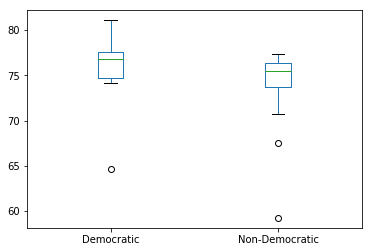

In [34]:
df_life_exps.plot(kind='box')

There seem to be outliers in both groups. We will plot a histogram and a Q-Q-plot to roughly check for normal distribution

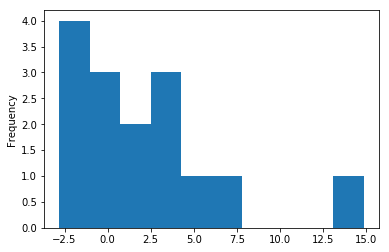

In [39]:
df_life_exps['difference'] = df_life_exps['Democratic'] - df_life_exps['Non-Democratic']

df_life_exps['difference'].plot(kind='hist')

Text(0.5, 1.0, 'Life Expectancy Difference Q-Q Plot')

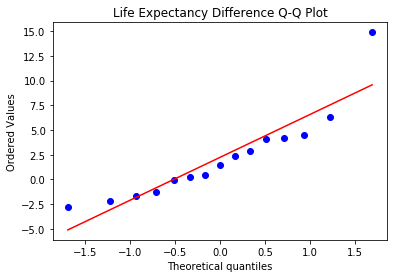

In [40]:
stats.probplot(df_life_exps['difference'], plot= plt)
plt.title('Life Expectancy Difference Q-Q Plot')

The life expectancy seems to be non-normally distributed. T-Tests assume this normal distribution, though. While in large samples this problem is not as severe (see [1]), in our sample with only 15 valid pairs this can lead to false negatives.

[1]: http://thestatsgeek.com/2013/09/28/the-t-test-and-robustness-to-non-normality/

In [41]:
# paired sampled t-Test to determine whether the differences between the life exp of the countries
# are statistically significant or not

stats.ttest_rel(df_life_exps['Democratic'], df_life_exps['Non-Democratic'])

Ttest_relResult(statistic=1.949452347337056, pvalue=0.07156337144503375)

The t-test shows that, even though there seems to be a slight difference in Life Expectancy, the findings are not statistically significant with p > 0.05.
## Discussion and reflection
The fact that there were no significant findings in the effect of the democratic status on the life expectancy does not mean that this effect does not exist. The methods used here could (and should) be improved in further research to paint a more accurate picture.
One point for discussion is the high threshold for a country to be fully democratic. A look at the (very short) list of democratic countries (by the definition of a democratic status > 8.0) shows that, for example, many members of the EU are not on this list, including countries like Germany, The Netherlands and Norway, which are generally accepted as being 'democratic' countries.
Using a lower threshold for defining 'democratic' countries would lead to a more accurate and hopefully more evenly distributed list which would allow for more pairs. This, in turn, would improve the accuracy of the tests.


# Schelling‘s Model of Segregation

### a) Create grid
Wbrite a function create_grid (shape, share_red, share_blue) that returns a numpy array of the given shape (rows, columns). Cells with a red agent should be marked with the value 1, cells with a blue agent with value 2, empty cells with a 0.

Naturally, share_red + share_blue < 0

In [35]:
import random
from random import randint
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.colors import ListedColormap
import pandas as pd
import numpy as np

In [36]:
def place_agent(color, grid):
    placed = False
    x = randint(0, grid.shape[0]-1)
    y = randint(0, grid.shape[1]-1)
    while placed is False:
        if grid[x,y] != 0:
            #print('could not place {0} at ({1},{2})'.format(color,x,y))
            x = randint(0, grid.shape[0]-1)
            y = randint(0, grid.shape[1]-1)
        else:
            grid[x,y] = color
            #print('placed {0} at ({1},{2})'.format(color, x, y))
            placed = True

    

In [37]:
# @shape: shape[0] defines the # of rows, shape[1] the # of cols
# @share_red: percentage of red's share (e.g. 0.4 for 40%)
# @share_blue: percentage of blue's share (e.g. 0.4 for 40%)
# NB: share_red + share_blue MUST be <= 1!



def create_grid(shape, share_red, share_blue) :
    #initialize a grid with all 0s
    grid = np.zeros([shape[0], shape[1]], dtype=int)
    #print(grid.shape)
    # apply the reds (1s) to the grid
    for i in range(round(shape[0] * shape[1] * share_red)):
        place_agent(1, grid)

                
    # apply the blues (2s) to the grid
    for i in range(round(shape[0] * shape[1] * share_blue)):
        place_agent(2, grid)
                
    return grid
    
grid = create_grid((100, 100), 0.4, 0.5)
print(grid)

#print(get_neighborhood((4,1), grid))

[[2 2 1 ... 1 2 1]
 [1 0 2 ... 1 2 1]
 [2 2 1 ... 2 2 1]
 ...
 [2 1 2 ... 1 2 2]
 [2 2 2 ... 2 2 2]
 [1 2 2 ... 1 1 1]]


### b) Visualization

Write a function visualize(grid) that take a numpy array with these properties and plots it. We recommend to use matplotlib for this

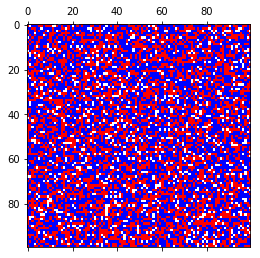

In [38]:
def visualize(grid):
    # we define the colormap: white for empty, red for 1, blue for 2
    cmap = ListedColormap(['w', 'r', 'b'])
    plt.matshow(grid, cmap=cmap)
    plt.show()
visualize(grid)

### c) Simulation Step

Simulate a single step (potential movement of a single randomly picked agent) of the Schelling model with a function simulate(grid, preferred_proportion)

In [39]:
def get_neighborhood(position, grid):
    list = []
    neighbor_cells = {(-1, 1), (0, 1), (1, 1), (-1, 0), (1, 0), (-1, -1), (0,-1), (1,-1)}
    for cell in neighbor_cells:
        if (position[0] + cell[0] >= 0 and position[0] + cell[0] < grid.shape[0]):
            if (position[1] + cell[1] >= 0 and position[1] + cell[1] < grid.shape[1]):
                n_x = position[0] + cell[0]
                n_y = position[1] + cell[1]
                list.append(grid[n_x, n_y])
    return list

def agent_happy(position, grid, preferred_proportion):
    self = grid[position[0], position[1]]
    others = who_are_they(self)
    neighborhood = get_neighborhood(position, grid)
    #print('self: {0}, others: {1}, neighborhood: {2}'.format(self, others, neighborhood))
    if self != 0:
        if neighborhood.count(others) > 0:
            if neighborhood.count(self) / (neighborhood.count(others) + neighborhood.count(0)) < preferred_proportion:
                #print('unhappy agent at {0}'.format(position))
                place_agent(self, grid) #relocate the agent
                grid[position[0], position[1]] = 0 #vacant the spot

# we called the function "simulate_1" to avoid conflicts with the simulate() in d)
def simulate_1(grid, preferred_proportion):
    for i in range(grid.shape[0]-1):
        for j in range(grid.shape[1]-1):
            #print('position: {0},{1}'.format(i,j))
            agent_happy((i,j), grid, preferred_proportion)
            
def who_are_they(self):
    if self == 1:
        return 2
    if self == 2:
        return 1
    else:
        return 0

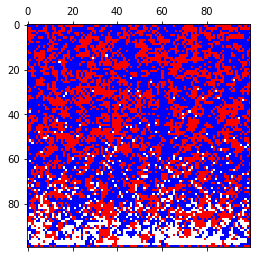

In [40]:
simulate_1(grid, 0.7)
visualize(grid)

### d) Full Simulation

Write a function simulate(grid, preferred_proportion, max_steps, no_changes_steps, iterations_to_next_vizualization) that performs a full simulation of Schelling's model given a specific start state by performing steps until the maximum number of steps is reached or the was no change for the given amount of steps. Every iterations_to_next_vizualization steps, a visualization of the model should be plotted.


In [41]:
def simulate(grid, preferred_proportion, max_steps, no_changes_steps, iterations_to_next_vizualization):
    steps = 0
    happy_steps = 0
    visualize(grid)
    grid_old = np.copy(grid)
    can_continue = True
    
    while can_continue is True:
        for i in range(grid.shape[0]):
            for j in range(grid.shape[1]):
                #print('position: {0},{1}'.format(i,j))
                agent_happy((i,j), grid, preferred_proportion)
        steps = steps + 1
        #print('current no. of steps: {0}'.format(steps))
        if (np.array_equal(grid, grid_old)) is True:
            happy_steps += 1
            #print('happy steps: {0}'.format(happy_steps))
        elif (np.array_equal(grid, grid_old)) is False:
            happy_steps = 0
            #print('happy steps reset: {0}'.format(happy_steps))
            grid_old = np.copy(grid)
        if steps % iterations_to_next_vizualization == 0:
            visualize(grid)
        if happy_steps >= no_changes_steps:
            print('No changes for {0} steps, seems like everyone is happy.'.format(happy_steps))
            can_continue = False
            break
        if steps >= max_steps:
            print('Reached no. of max steps: {0}'.format(max_steps))
            can_continue = False
            break
    print('\n\nFinal result, reached after {0} steps: '.format(steps))
    visualize(grid)

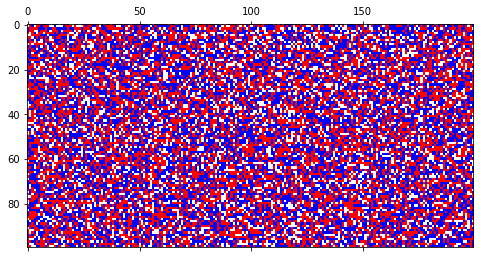

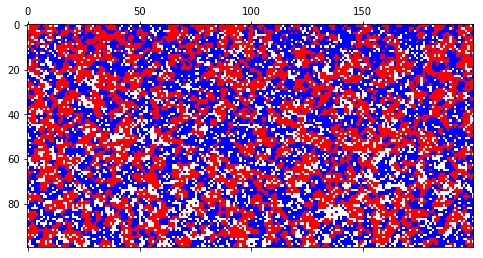

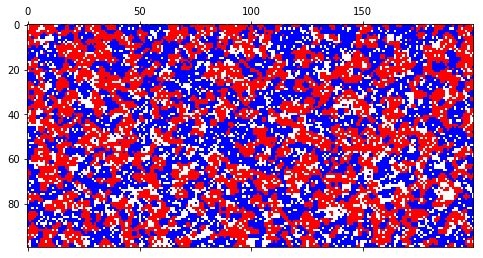

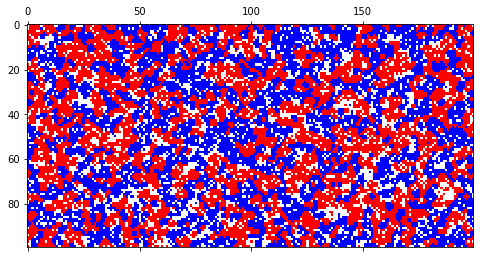

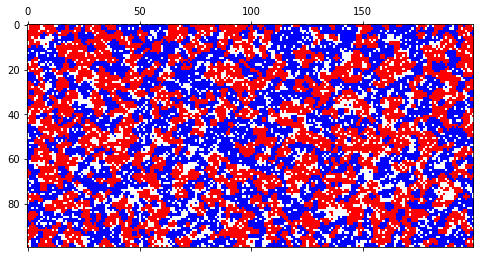

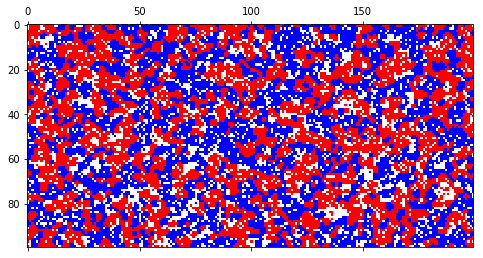

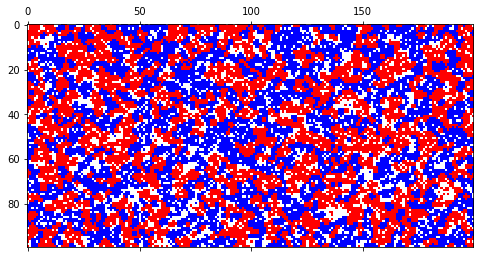

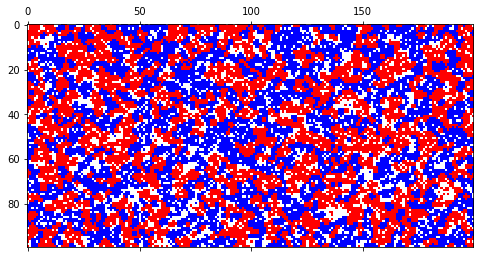

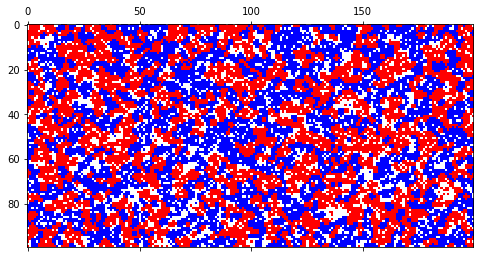

No changes for 5 steps, seems like everyone is happy.


Final result, reached after 16 steps: 


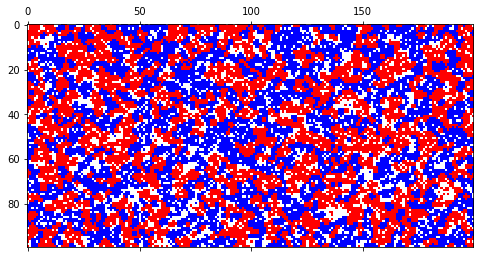

In [88]:
grid = create_grid((100, 200), 0.4, 0.4)
simulate(grid, 0.4, 100, 5, 2)

### e) Model Extension

Edit your functions such that they support multiple groups (instead of just red and blue), and each group can have a separate preferred proportion. Use for this the following signatures

create_grid (shape, shares): percentages should be a list of shares for each color
visualize(grid) => choose appropriate colors
Simulate a single step (potential movement of a single randomly picked agent) of the Schelling model with a function simulate(grid, preferred_proportions) => Gives a list of preferred proportions for each color.


In [ ]:
# First we copied some functions from above to edit them accordingly

def agent_happy(position, grid, preferred_proportion):
    self = grid[position[0], position[1]]
    others = who_are_they(self)
    neighborhood = get_neighborhood(position, grid)
    #print('self: {0}, others: {1}, neighborhood: {2}'.format(self, others, neighborhood))
    if self != 0:
        if neighborhood.count(others) > 0:
            if neighborhood.count(self) / (neighborhood.count(others) + neighborhood.count(0)) < preferred_proportion:
                #print('unhappy agent at {0}'.format(position))
                place_agent(self, grid) #relocate the agent
                grid[position[0], position[1]] = 0 #vacant the spot

# we called the function "simulate_1" to avoid conflicts with the simulate() in d)
def simulate_1(grid, preferred_proportion):
    for i in range(grid.shape[0]-1):
        for j in range(grid.shape[1]-1):
            #print('position: {0},{1}'.format(i,j))
            agent_happy((i,j), grid, preferred_proportion)
            
def who_are_they(self):
    if self == 1:
        return 2
    if self == 2:
        return 1
    else:
        return 0